<a id="title_ID"></a>
# JWST Pipeline Validation Testing Notebook: MIRI LRS Slitless spectroscopy
# Step: photom() in Spec2Pipeline

<span style="color:red"> **Instruments Affected**</span>: MIRI 

### Table of Contents
<div style="text-align: left"> 

<br> [Imports](#imports_ID) <br> [Introduction](#intro_ID) <br> [Get Documentaion String for Markdown Blocks](#markdown_from_docs) <br> [Loading Data](#data_ID) <br> [Run JWST Pipeline](#pipeline_ID) <br> [Create Figure or Print Output](#residual_ID) <br> [About This Notebook](#about_ID) <br>

</div>

<a id="imports_ID"></a>
# Imports
List the library imports and why they are relevant to this notebook.


* os for simple operating system functions
* glob for file finding
* gwcs.wcstools for bounding box operations
* astropy.io for opening fits files
* inspect to get the docstring of our objects.
* IPython.display for printing markdown output
* jwst.datamodels for building model for JWST Pipeline
* jwst.module.PipelineStep is the pipeline step being tested
* Various pipeline steps
* Various datamodels
* matplotlib.pyplot to generate plot
* matplotlib.patches to plot shapes
* crds for retrieving a reference file
* scipy interpolate
* ci_watson for data retrieval from artifactory


[Top of Page](#title_ID)

In [13]:
from ci_watson.artifactory_helpers import get_bigdata
from astropy.io import fits
import matplotlib.pyplot as plt
import statistics as stat
import numpy as np
from jwst.pipeline import Detector1Pipeline, Spec2Pipeline, collect_pipeline_cfgs
from jwst.pipeline import Spec2Pipeline
from jwst.background import BackgroundStep
from jwst.assign_wcs import AssignWcsStep
from jwst.extract_2d import Extract2dStep
from jwst.flatfield import FlatFieldStep
from jwst.photom import PhotomStep
from scipy import interpolate
from jwst.datamodels import ImageModel, CubeModel, RampModel
import crds
import os
import glob
from jwst import datamodels
from gwcs.wcstools import grid_from_bounding_box

2021-01-25 11:03:16,264 - stpipe - WARNING - /Users/skendrew/anaconda3/envs/jwst0.17.1/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



In [14]:
Slitlessfile = get_bigdata('jwst_validation_notebooks',
                                     'validation_data',
                                     'calwebb_tso3',
                                    'tso3_miri_test',
                                    'pipetest_miri_lrs_tso_100G10I.fits')

In [15]:
if not os.path.exists('../cfg_files/'):
    os.mkdir('../cfg_files/')
    cfgs = collect_pipeline_cfgs.collect_pipeline_cfgs(dst='../cfg_files/')

In [16]:
# Box file location:
det1 = Detector1Pipeline.call(Slitlessfile, config_file='../cfg_files/calwebb_tso1.cfg', save_results=True)

2021-01-25 11:04:16,260 - CRDS - ERROR -  Error determining best reference for 'pars-rscd_step'  =   Unknown reference type 'pars-rscd_step'
2021-01-25 11:04:16,298 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2021-01-25 11:04:16,299 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2021-01-25 11:04:16,301 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2021-01-25 11:04:16,302 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2021-01-25 11:04:16,304 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2021-01-25 11:04:16,305 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2021-01-25 11:04:16,307 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2021-01-25 11:04:16,308 - stpipe.Detector1Pipeline.rscd - INFO - RSCD_Step instance created.
2021-01-25 11:04:16,309 - stpipe.Detector1Pipeline.firstframe - INFO - First

2021-01-25 11:04:16,706 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/Users/skendrew//crds_cache/references/jwst/miri/jwst_miri_saturation_0026.fits'.
2021-01-25 11:04:16,707 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.
2021-01-25 11:04:16,707 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...
2021-01-25 11:04:16,995 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(10, 100, 416, 72) from pipetest_miri_lrs_tso_100G10I.fits>,).
2021-01-25 11:04:16,997 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/skendrew/jwst_pipeline/jwst_validation_notebooks/jwst_validation_notebooks

2021-01-25 11:04:19,419 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=10, ngroups=100, nframes=1, groupgap=0
2021-01-25 11:04:19,420 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=1000, nframes=1, groupgap=0
2021-01-25 11:04:19,575 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done
2021-01-25 11:04:19,690 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(10, 100, 416, 72) from pipetest_miri_lrs_tso_100G10I.fits>,).
2021-01-25 11:04:19,691 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/skendrew/jwst_pipeline/jwst_validation_notebooks/jwst_validation_notebooks/photom', 'odd_even_columns': True, 'use_side_ref

2021-01-25 11:05:31,216 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file
2021-01-25 11:05:31,216 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped
2021-01-25 11:05:31,219 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done
2021-01-25 11:05:31,295 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(10, 416, 72) from pipetest_miri_lrs_tso_100G10I_ramp.fits>,).
2021-01-25 11:05:31,296 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/Users/skendrew/jwst_pipeline/jwst_validation_notebooks/jwst_validation_notebooks/photom'}
2021-01-25 11:05:31,320 - stpipe.Detector1Pipeline.gain_scale - INFO 

In [17]:
rifile = glob.glob('*_rateints.fits')
print(rifile)

det1_ints = datamodels.open(rifile[0])

2021-01-25 11:05:52,063 - stpipe - WARNING - /Users/skendrew/anaconda3/envs/jwst0.17.1/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



['pipetest_miri_lrs_tso_100G10I_rateints.fits']


In [20]:
#pipe2 = Spec2Pipeline()
#pipe2.flat_field.save_results = True
#pipe2.extract_1d.skip= True

sp2 = Spec2Pipeline.call(det1_ints, config_file='../cfg_files/calwebb_tso-spec2.cfg', steps={'flat_field': {'save_results': True}, 'extract_1d': {'skip': True}})
print(sp2)

2021-01-25 11:11:35,889 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2021-01-25 11:11:35,891 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2021-01-25 11:11:35,893 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2021-01-25 11:11:35,894 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2021-01-25 11:11:35,896 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2021-01-25 11:11:35,897 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.
2021-01-25 11:11:35,900 - stpipe.Spec2Pipeline.master_background - INFO - MasterBackgroundNrsSlitsStep instance created.
2021-01-25 11:11:35,901 - stpipe.Spec2Pipeline.master_background.flat_field - INFO - FlatFieldStep instance created.
2021-01-25 11:11:35,903 - stpipe.Spec2Pipeline.master_background.pathloss - INFO - PathLossStep instance created.
2021-01-25 11:11:35,904 - stpipe.Spec2Pipeline.master_

2021-01-25 11:11:36,052 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'pipetest_miri_lrs_tso_100G10I_rateints.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'resol', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']
2021-01-25 11:11:36,060 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2021-01-25 11:11:36,061 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2021-01-25 11:11:36,062 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2021-01-25 11:11:36,062 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2021-01-25 11:11:36,063 - stpipe.Spec2Pipeline - INFO - Prefetch for CUBEPAR reference file is 'N/A'.
2021-01-

2021-01-25 11:11:36,939 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2021-01-25 11:11:36,948 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_LRS-SLITLESS
2021-01-25 11:11:36,949 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None
2021-01-25 11:11:36,949 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead
2021-01-25 11:11:36,950 - stpipe.Spec2Pipeline.srctype - INFO - Input is a TSO exposure; setting SRCTYPE = POINT
2021-01-25 11:11:36,951 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done
2021-01-25 11:11:37,022 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<CubeModel(10, 416, 72) from pipetest_miri_lrs_

[<CubeModel(10, 416, 72) from pipetest_miri_lrs_tso_100G10I_calints.fits>]


2021-01-25 11:17:12,592 - stpipe - WARNING - <ipython-input-24-2849b6bb51c7>:13: RuntimeWarning: invalid value encountered in true_divide
  ax[2].imshow(sp2[0].data[0,:,:]/ff.data[0,:,:], origin='lower', interpolation='None')



1
['pipetest_miri_lrs_tso_100G10I_flat_field.fits']


Text(0.5, 1.0, 'calints/ff, Int 1')

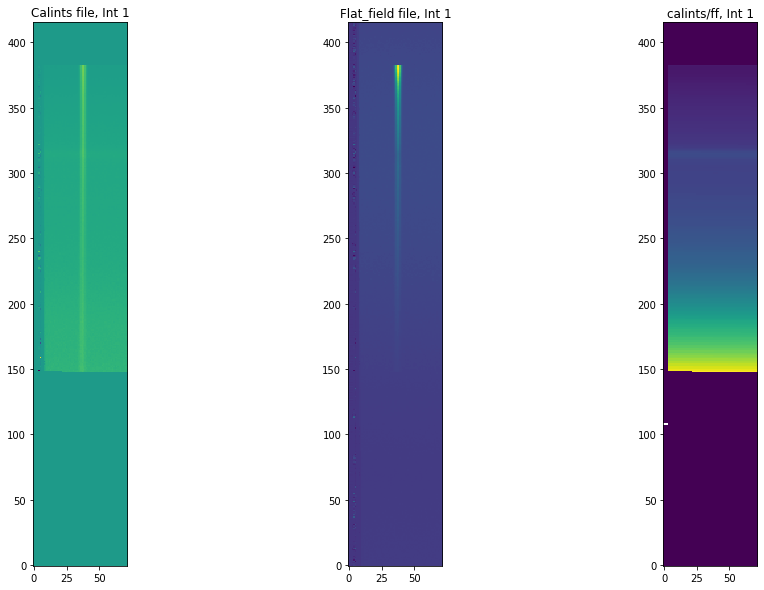

In [24]:
print(len(sp2))
ffile = glob.glob('pipetest*_flat_field.fits')
print(ffile)

ff = datamodels.open(ffile[0])
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=[16,10])
ax[0].imshow(sp2[0].data[0,:,:], origin='lower', interpolation='None')
ax[0].set_title('Calints file, Int 1')

ax[1].imshow(ff.data[0,:,:], origin='lower', interpolation='None')
ax[1].set_title('Flat_field file, Int 1')

ax[2].imshow(sp2[0].data[0,:,:]/ff.data[0,:,:], origin='lower', interpolation='None')
ax[2].set_title('calints/ff, Int 1')



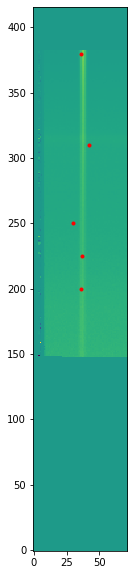

[array(5.15320404), array(10.94665985), array(10.3880848), array(8.09935636), array(9.78794071)]


In [45]:
pho = sp2[0]
point1 = (36,380)
ra1, dec1, wave1 = pho.meta.wcs(point1[0],point1[1])
point2 = (36,200)
ra2, dec2, wave2 = pho.meta.wcs(point2[0],point2[1])
point3 = (37,225)
ra3, dec3, wave3 = pho.meta.wcs(point3[0],point3[1])
point4 = (42,310)
ra4, dec4, wave4 = pho.meta.wcs(point4[0],point4[1])
point5 = (30,250)
ra5, dec5, wave5 = pho.meta.wcs(point5[0],point5[1])
fig = plt.figure(figsize=[4,10])
plt.imshow(pho.data[0], origin='lower', interpolation='None')
plt.plot([point1[0],point2[0],point3[0],point4[0],point5[0]],[point1[1],point2[1],point3[1],point4[1],point5[1]],'.', color='r')
plt.show()
xpts = [point1[0], point2[0], point3[0], point4[0], point5[0]]
ypts = [point1[1], point2[1], point3[1], point4[1], point5[1]]

waves = [wave1, wave2, wave3, wave4, wave5]
print(waves)

In [46]:
phoreffile = pho.meta.ref_file.photom.name
file = phoreffile.split("/")[2]
basename = crds.core.config.pop_crds_uri(phoreffile)
path = crds.locate_file(basename, "jwst")
reffile = datamodels.open(path)
print(phoreffile)

crds://jwst_miri_photom_0071.fits


In [47]:
wavelocs = []
relresp = []


wloc = [np.argmin(np.abs(reffile.phot_table['wavelength'] - ww)) for ww in waves]
wmatch = [reffile.phot_table['wavelength'][0,ll] for ll in wloc]
wmatch_plus = [reffile.phot_table['wavelength'][0,ll+1] for ll in wloc]
wmatch_minus = [reffile.phot_table['wavelength'][0,ll-1] for ll in wloc]
relresp = [reffile.phot_table['relresponse'][0,ll] for ll in wloc]
print(relresp)

[0.5033188, 3.7477894, 2.585046, 1.5743923, 2.0205958]


2021-01-26 07:36:21,793 - stpipe - WARNING - <ipython-input-48-199054cbf2f3>:15: RuntimeWarning: invalid value encountered in true_divide
  ref_ratio = sp2[0].data[0,6:397,:]/ff.data[0,6:397,:]



((3.5, 71.5), (6.5, 397.5))


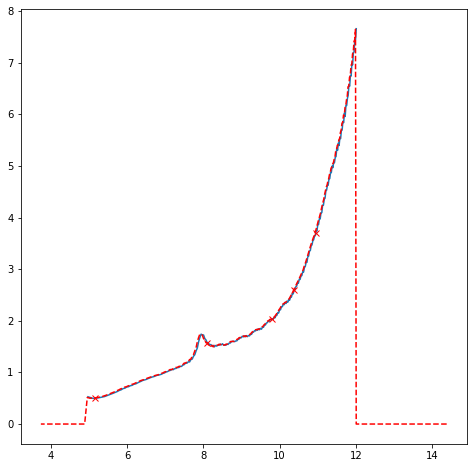

In [48]:
f = interpolate.interp1d(reffile.phot_table['wavelength'][0,:], reffile.phot_table['relresponse'][0,:], assume_sorted=False)
iresp = [f(ww) for ww in waves]

print(pho.meta.wcs.bounding_box)

# plot for sanity check!
plt.figure(figsize=[8,8])
plt.plot(reffile.phot_table['wavelength'][0,:], reffile.phot_table['relresponse'][0,:])
plt.plot(waves, iresp, 'rx', label='interpolated points')


x,y = grid_from_bounding_box(pho.meta.wcs.bounding_box)
ra, dec, lam = pho.meta.wcs(x, y)

ref_ratio = sp2[0].data[0,6:397,:]/ff.data[0,6:397,:]
ref_ratio_av = np.mean(ref_ratio[:,25:45], axis=1)

lam_vec = np.mean(lam, axis=1)
plt.plot(lam_vec, ref_ratio_av/reffile.phot_table['photmjsr'][0], 'r--')
plt.show()

In [49]:
fconv = [reffile.phot_table['photmjsr'][0] * ir for ir in iresp]
print(fconv)

2021-01-26 07:36:26,369 - stpipe - WARNING - /Users/skendrew/anaconda3/envs/jwst0.17.1/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



[17.69197639579638, 130.3850202516898, 91.40632416687826, 55.55319233912916, 71.49935991826705]


In [50]:
dratio = [pho.data[0,yy,xx]/ff.data[0,yy,xx] for xx,yy in zip(xpts, ypts)]

# print these numbers next to each other to see if they match
print('Ratio of data points     Calculated conversion factor')
for rr, fc in zip(dratio, fconv):
    print('{0:.5f}                {1:.5f}'.format(rr,fc))
    assert np.isclose(rr,fc, rtol=1e-6), "Numbers don't match to within 1e-6"

Ratio of data points     Calculated conversion factor
17.69198                17.69198
130.38503                130.38502
91.40633                91.40632
55.55319                55.55319
71.49936                71.49936


2021-01-26 07:37:58,573 - stpipe - WARNING - <ipython-input-51-d1ac5255ec8d>:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()



((3.5, 71.5), (6.5, 397.5))
(10, 391, 72)
391


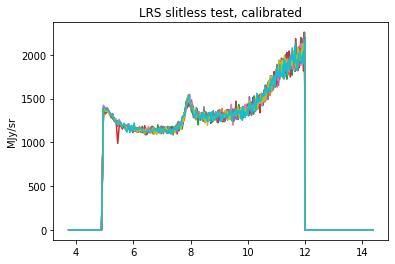

In [51]:
x,y = grid_from_bounding_box(ff.meta.wcs.bounding_box)
ra, dec, lam = ff.meta.wcs(x, y)

lam_vec = np.mean(lam, axis=1)

print(ff.meta.wcs.bounding_box)

flat_test = ff.data[:,6:397, :]
pho_test = pho.data[:,6:397, :]


print(np.shape(flat_test))
print(len(lam_vec))
fig = plt.figure()
for i in range(10):
    plt.plot(lam_vec, pho_test[i,:,40])
    #plt.plot(lam_vec, flat_test[i,:,40])
    
plt.title('LRS slitless test, calibrated')
plt.ylabel('MJy/sr')
plt.savefig('photom_slitless_test_cal.png')
fig.show()

**Authors**
* K. Murray, kmurray@stsci.edu, MIRI Branch
* S. Kendrew, sarah.kendrew@esa.int, ESA/MIRI Branch

Last updated
Jan 14th 2021